In [1]:
%load_ext jupyter_black
%matplotlib inline

In [2]:
import numpyro

numpyro.set_platform("cpu")  # cpu if using mac
# numpyro.set_platform("gpu")

/Users/riddhi/Library/CloudStorage/OneDrive-Nexus365/Oxford/Research Projects/Ox_AgencyParadox/1_Data&Analysis/pybefit/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from typing import Dict, List, Optional
from jaxtyping import Array, PRNGKeyArray
from functools import partial

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import equinox as eqx

import jax.random as jr
import jax.numpy as jnp
import jax.tree_util as jtu

from jax import nn, lax, vmap

from pymdp.jax.agent import Agent as AIFAgent

from pybefit.inference import (
    run_nuts,
    run_svi,
    default_dict_nuts,
    default_dict_numpyro_svi,
)

from pybefit.inference import NumpyroModel, NumpyroGuide
from pybefit.inference import Normal, NormalPosterior
from pybefit.inference.numpyro.likelihoods import pymdp_likelihood as likelihood

from numpyro.infer.autoguide import AutoNormal, AutoMultivariateNormal
from numpyro.infer import Predictive

from pymdp.jax.task import PyMDPEnv
from pymdp.utils import random_A_matrix, random_B_matrix
from equinox import Module, field

seed_key = jr.PRNGKey(101)

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2024-04-27 15:48:05.304464: W pjrt_plugin/src/mps_client.cc:563] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!


# Two-agent agency task:
This script conducts model fitting using an active inference simulation of the two-agent (participant + simulated participant) agency task. Behavioural data was collected by Riddhi J. Pitliya and her colleagues. <br> 

The task involves two participants, one real (the focal participant whose point of view we are 
creating the active inference model), and a fake participant (simulated in the computer 
program).  <br>

The focal participant sees two buttons on the screen, and it has control over one button. They 
are told that there is another participant, which has control over the other button, but they do 
not know that the other participant just randomly produces an action (i.e., pressing the button 
50% of the time, across all trials and blocks). The focal participant can freely produce or not 
produce actions and an outcome would be present or absent according to the experimental 
condition.  <br> 

Over a series of trials (25 trials), the focal participant is to learn how much control 
they, and the other agent, have over producing the outcome (outcome_present). They are 
instructed to produce the outcome as much as possible.  <br> 

At the end of the series of trials (25 trials), participants are asked two questions: (1) How 
much control did you have?, and (2) How much control did the simulated participant have?. 
Participants respond on a rating scale from -10 to +10, where negative values mean inverse 
control (action_present --> outcome_absent; and action_absent --> outcome_present), and 
positive values mean excitatory control (action_present --> outcome_present; and 
action_absent --> outcome_absent).  <br>

Participants can be in one of five experimental conditions at one time. They complete all five 
experimental conditions, in a random order. The experimental conditions are: "s_zer_o_neg", 
"s_neg_o_zer", "s_zer_o_zer", "s_pos_o_zer", "s_zer_o_pos". All conditions are 
deterministic, so, "s_zer_o_neg" indicates that the Self (or focal participant) has 100% Zero 
control, and the Other (simulated participant) has 100% Negative control. <br>

In the active inference simulation, the focal agent is inferring the following states: ['selfPositive_otherPositive', 'selfPositive_otherNegative', 'selfNegative_otherPositive', 'selfNegative_otherNegative']. The agent is then to report a rating for the self and other by: 
* self_rating = ('selfPositive_otherPositive' + 'selfPositive_otherNegative') - ('selfNegative_otherPositive' + 'selfNegative_otherNegative') <br>
* other_rating = ('selfPositive_otherPositive' + 'selfNegative_otherPositive') - ('selfPositive_otherNegative' + 'selfNegative_otherNegative')




# Defining the States and Observations for this task

In [4]:
""" Defining state factors """

agency_names = [
    "selfPositive_otherPositive",
    "selfPositive_otherNegative",
    "selfNegative_otherPositive",
    "selfNegative_otherNegative",
]
self_action_names = ["self_buttonpress", "self_buttonnotpress"]
other_action_names = ["other_buttonpress", "other_buttonnotpress"]

""" Defining number of state factors and states """
num_states = [len(agency_names), len(self_action_names), len(other_action_names)]
num_factors = len(num_states)

""" Defining control state factors """
choice_agency_names = ["no_changes"]
choice_self_action_names = ["self_pressbutton", "self_notpressbutton"]
choice_other_action_names = ["equal_distribution"]

""" Defining number of control states """
num_controls = [
    len(choice_agency_names),
    len(choice_self_action_names),
    len(choice_other_action_names),
]

""" Defining observational modalities """
obs_outcome_names = ["outcome_present", "outcome_absent"]
obs_choice_self_names = ["self_buttonpress", "self_buttonnotpress"]
obs_choice_other_names = ["other_buttonpress", "other_buttonnotpress"]

""" Defining number of observational modalities and observations """
num_obs = [
    len(obs_outcome_names),
    len(obs_choice_self_names),
    len(obs_choice_other_names),
]
num_modalities = len(num_obs)

# Defining the Generative Process

In [5]:
""" Defining experimental structure """

batch_size = 80  # number of subjects
num_blocks = 15  # number of block of trials, one per condition; there are 5 conditions that are repeated three times
num_timesteps = 25  # number of timesteps/trials in each block
num_exp_conditions = 5  # number of experimental conditions

""" Defining the generative process """


def make_agency_task(p_outcome_env=1.0, p_other_action_env=0.5):
    a1 = jnp.array([p_outcome_env, 1 - p_outcome_env])  # [1.0, 0.0]
    a2 = 1 - a1  # [0.0, 1.0]
    a3 = jnp.array([0.5, 0.5])
    A1 = jnp.stack(
        [a1, a2, a1, a2, a3], -1
    )  # setting up the A tensor for self_press, other_press
    A2 = jnp.stack(
        [a1, a2, a2, a1, a3], -1
    )  # setting up the A tensor for self_press, other_notpress
    A3 = jnp.stack(
        [a2, a1, a1, a2, a3], -1
    )  # setting up the A tensor for self_notpress, other_press
    A4 = jnp.stack(
        [a2, a1, a2, a1, a3], -1
    )  # setting up the A tensor for self_notpress, other_notpress
    _A = jnp.stack([A1, A2, A3, A4], -1).reshape(2, 5, 2, 2)

    a = jnp.eye(2)
    A = [
        jnp.broadcast_to(
            _A, (batch_size,) + _A.shape
        ),  # the first A tensor (for outcome) is defined above
        jnp.broadcast_to(
            a, (batch_size,) + a.shape
        ),  # the second A tensor (for self_action) is an identity matrix
        jnp.broadcast_to(
            a, (batch_size,) + a.shape
        ),  # the third A tensor (for other_action) is an identity matrix
    ]

    B2 = jnp.stack([jnp.array([[1, 1], [0, 0]]), jnp.array([[0, 0], [1, 1]])], -1)
    B = [
        jnp.broadcast_to(
            jnp.eye(num_exp_conditions)[..., None],
            (batch_size, num_exp_conditions, num_exp_conditions, 1),
        ),
        jnp.broadcast_to(B2, (batch_size, 2, 2, 2)),
        jnp.broadcast_to(
            jnp.ones((num_states[-1], num_states[-1], 1)) / num_states[-1],
            (batch_size, num_states[-1], num_states[-1], 1),
        ),
    ]

    D = [
        jnp.ones((batch_size, 5)) / 5,
        jnp.ones((batch_size, num_states[1])) / num_states[1],
        jnp.ones((batch_size, num_states[2])) / num_states[2],
    ]

    dependencies = {"A": [[0, 1, 2], [1], [2]], "B": [[0], [1], [2]]}

    params = {"A": A, "B": B, "D": D}

    return PyMDPEnv(params, dependencies=dependencies)


agency_task = make_agency_task()
key, _key = jr.split(seed_key)
agency_task = agency_task.reset(_key)

In [6]:
print(len(agency_task.params["A"]))  # so, there are three A tensors

# (num_participants, num_outcome_observations, num_experimental_conditions, num_self_action_states, num_other_action_states)
print(agency_task.params["A"][0].shape)

# (num_participants, num_self_action_observations, num_self_action_states)
print(agency_task.params["A"][1].shape)

# (num_participants, num_otheraction_observations, num_other_action_states)
print(agency_task.params["A"][2].shape)


# printing out the A tensor for self_press, other_press, given the experimental conditions are:
# s_pos_o_zero    s_neg_o_zer    s_zer_o_pos      s_zer_o_neg     s_zer_o_zer
# change the last two values to set the combition of self and other action
agency_task.params["A"][0][0, ..., 0, 0]

3
(80, 2, 5, 2, 2)
(80, 2, 2)
(80, 2, 2)


Array([[1. , 0. , 1. , 0. , 0.5],
       [0. , 1. , 0. , 1. , 0.5]], dtype=float32)

In [7]:
print(len(agency_task.params["B"]))  # so, there are three B tensors

# (num_participants, num_experimental_conditions at t+1, num_experimental_conditions at t, 1 dimension - i.e., agent has no control over it)
print(agency_task.params["B"][0].shape)

# (num_participants, num_self_action_states at t+1, num_self_action_states at t, agent can control it in 2 ways (to press, or not))
print(agency_task.params["B"][1].shape)

# (num_participants, num_other_action_states at t+1, num_other_action_states at t, 1 dimension - i.e., agent has no control over it)
print(agency_task.params["B"][2].shape)


# printing out the B tensor[0]
# change the last value to see how the states can be controlled
agency_task.params["B"][1][0, ..., 0]

3
(80, 5, 5, 1)
(80, 2, 2, 2)
(80, 2, 2, 1)


Array([[1, 1],
       [0, 0]], dtype=int32)

In [8]:
# setting keys to num_participants + 1 to ensure each participant has a unique random key
keys = jr.split(key, batch_size + 1)
key = keys[-1]

# initiating actions for all participants as [0,0,0]
actions = jnp.broadcast_to(jnp.array([0, 0, 0]), (batch_size, 3))

# step through the simulation via generative process defined above, loading a unique key for each participant, and creating observations
obs, agency_task = agency_task.step(keys[:batch_size], actions)

# Defining the Generative Model 

In [9]:
def broadcast_to_batch(xs, batch_size):
    return jtu.tree_map(lambda x: jnp.broadcast_to(x, (batch_size,) + x.shape), xs)


def create_A(batch_size, p_outcome_mean, p_outcome_scale):
    ### make components for first modality
    a1 = jnp.stack([p_outcome_mean, 1 - p_outcome_mean], -1)  # [1.0, 0.0]
    a = jnp.ones_like(a1) / 2  # [0.5, 0.5]

    # self_pos, other_pos
    A1 = jnp.stack([a1, a, a, 1 - a1], -1)

    # self_pos, other_neg
    A2 = jnp.stack([a, 1 - a1, a1, a], -1)

    # sef_neg, other_pos
    A3 = jnp.stack([a, a1, 1 - a1, a], -1)

    # self_neg, other_neg
    A4 = jnp.stack([1 - a1, a, a, a1], -1)

    _A = jnp.stack([A1, A2, A3, A4], -1).reshape(batch_size, 2, 4, 2, 2)
    null_A = jnp.ones_like(_A[..., :1, :])
    A_outcome = jnp.concatenate(
        [null_A / 2, _A], -2
    )  # shape = (batch_size, 2, 4, 3, 2)

    _pA = jnp.expand_dims(p_outcome_scale, range(1, _A.ndim)) * _A
    pA_outcome = jnp.concatenate([1e4 * null_A, _pA], -2)

    ### A matrix for proprioception
    A_self_action = jnp.concatenate(
        [jnp.ones((2, 1)) / 2, jnp.eye(2)], -1
    )  # with null state shape = (2, 3)

    ### A matrix for observing other agent's actions
    tmp = jnp.broadcast_to(jnp.expand_dims(jnp.eye(2), -2), (2, 2, 2))
    A_other_action = jnp.concatenate(
        [jnp.ones((2, 1, 2)) / 2, tmp], -2
    )  # with null state shape = (2, 3, 2)

    A = [A_outcome] + broadcast_to_batch([A_self_action, A_other_action], batch_size)
    A_factor_list = [[0, 1, 2], [1], [1, 2]]

    ### make dirichlet prior
    pA = [pA_outcome] + jtu.tree_map(lambda x: 1e4 * x, A[1:])

    return A, A_factor_list, pA

In [10]:
# the number of states are now 4 (self_pos_other_pos, self_pos_other_neg, self_neg_other_pos, self_neg_other_neg),
# 3 (null, self_press, self_notpress), and - note that the null state ensures obs are nullified at first timestep
# 2 (other_press, other_notpress)
num_states = [4, 3, 2]


def create_B(batch_size):
    ### B matrix for context (agency)
    d = len(agency_names)
    B_context = jnp.expand_dims(jnp.eye(d), -1)  # identity matrix

    ### B matrix for actions the self can make
    B_self_choice = jnp.stack(
        [jnp.array([[1, 1], [0, 0]]), jnp.array([[0, 0], [1, 1]])], -1
    )
    B_self_choice = jnp.pad(
        B_self_choice, ((1, 0), (1, 0), (0, 0))
    )  # with null state shape = (3, 3, 2)

    # this is what the B tensor will look like for self_action:
    # [[[0, 0], [0, 0], [0, 0]],
    #  [[0, 0], [1, 0], [1, 0]],
    #  [[0, 0], [0, 1], [0, 1]]]

    ### B matrix for actions the other can make - a flat disribution
    d1, p1 = len(other_action_names), len(choice_other_action_names)
    B_other_choice = jnp.ones((d1, d1, p1)) / d1

    B = broadcast_to_batch([B_context, B_self_choice, B_other_choice], batch_size)
    dependencies = [[0], [1], [2]]

    return B, dependencies


def create_C(batch_size, outcomepref, actionpref):
    C1 = jnp.pad(outcomepref[..., None], ((0, 0), (0, 1)))
    C2 = jnp.pad(actionpref[..., None], ((0, 0), (0, 1)))
    C3 = jnp.zeros((batch_size, 2))

    return [C1, C2, C3]


def create_D(batch_size):
    D_context = jnp.array([0, 0.5, 0.5, 0])
    D_self_action = jnp.array([1.0, 0.0, 0.0])
    D_other_action = jnp.ones(num_states[-1]) / num_states[-1]

    return broadcast_to_batch([D_context, D_self_action, D_other_action], batch_size)


def create_E(batch_size, habit_press):
    log_E = jnp.pad(habit_press[..., None], ((0, 0), (0, 1)))
    return nn.softmax(log_E, -1)

# Setting up the model simulation for model fitting

In [11]:
num_params = 5
num_agents = batch_size
prior = Normal(num_params, num_agents, backend="numpyro")


def transform(z):
    # map z variables (tensors) to model parameters

    num_agents, np = (
        z.shape
    )  # retrieves the shape of the tensor z, where num_agents would be the number of participants and np is the number of parameters per participant

    assert np == 5  # test that we have exactly 5 parameters

    # mapping a slice of the z tensor to a specific model parameter, applying transformations to ensure meaningful z values for the model - i.e., adding priors for the parameter values
    # prior mean (~0.6 after transformations) and scale of learnable A_outcome
    p_outcome_mean = nn.sigmoid(0.45 + 0.0 * z[..., 0])
    p_outcome_scale = 1 + 0.0 * nn.softplus(z[..., 1])
    outcomepref = 5.0 + 0 * z[..., 2]  # prior preference over outcomes (the first C)
    actionpref = -1.0 + 0 * z[..., 3]  # prior preference over actions (the second C)
    habit_press = 0.0 + 0.0 * z[..., 4]  # prior over policies

    # creating the generative model
    A, A_dependencies, pA = create_A(num_agents, p_outcome_mean, p_outcome_scale)
    B, B_dependencies = create_B(num_agents)
    C = create_C(num_agents, outcomepref, actionpref)
    D = create_D(num_agents)
    E = create_E(num_agents, habit_press)
    pB = None  # not learniing B

    # return the aif agent class
    agents = AIFAgent(
        A,
        B,
        C,
        D,
        E,
        pA,
        pB,
        A_dependencies=A_dependencies,
        B_dependencies=B_dependencies,
        use_param_info_gain=True,
        inference_algo="fpi",
        learn_A=True,
        learn_B=False,
        learn_D=False,
        num_iter=8,
        alpha=16.0,
        gamma=1.0,
        sampling_mode="full",
        action_selection="stochastic",
    )
    return agents

In [12]:
num_params = 5
key, _key = jr.split(seed_key)
z = (
    jr.normal(_key, shape=(num_agents, num_params)) / 10
)  # generating a tensor (z) filled with normally distributed random values, scaled down by a factor of 10

agents = transform(z);  # transforming that z tensor using the function defined above

In [13]:
''' running model simulation '''

from pybefit.inference.methods import default_dict_nuts

# defining options for the task and model
opts_task = {
    "task": agency_task,
    "num_blocks": num_blocks,
    "num_trials": num_timesteps,
    "num_agents": num_agents,
}
opts_model = {"prior": {}, "transform": {}, "likelihood": opts_task}

model = NumpyroModel(prior, transform, likelihood, opts=opts_model)

pred = Predictive(
    model, num_samples=1
)  # creating a predictive distribution sample from a given probabilistic model that we defined above
key, _key = jr.split(key)
samples = pred(_key)

2024-04-27 15:52:16.084786: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-04-27 15:54:32.741882: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 4m16.661605s

********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


In [14]:
samples.keys()

dict_keys(['agent', 'beliefs', 'first_agent', 'multiaction_cat', 'multiaction_probs', 'multiactions', 'outcomes', 'states', 'z'])

In [15]:
''' extracting variables for plotting '''

exp_condition = samples["states"][-1][0][0]
last_beliefs_about_condition = samples["beliefs"][0][..., -1, :]

self_rating = (
    last_beliefs_about_condition[0, ..., 0]
    + last_beliefs_about_condition[0, ..., 1]
    - last_beliefs_about_condition[0, ..., 2]
    - last_beliefs_about_condition[0, ..., 3]
)
other_rating = (
    last_beliefs_about_condition[0, ..., 0]
    + last_beliefs_about_condition[0, ..., 2]
    - last_beliefs_about_condition[0, ..., 1]
    - last_beliefs_about_condition[0, ..., 3]
)

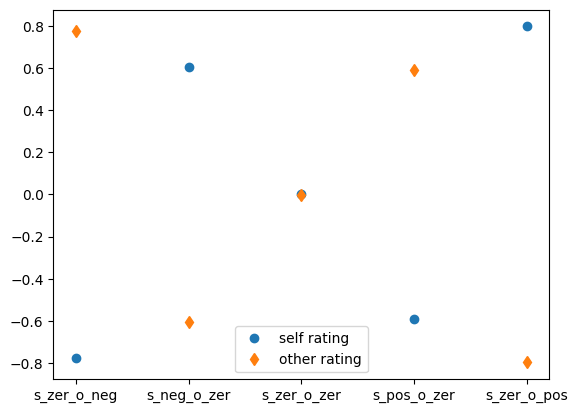

In [16]:
labels = {
    0: "s_pos_o_zer",
    1: "s_neg_o_zer",
    2: "s_zer_o_pos",
    3: "s_zer_o_neg",
    4: "s_zer_o_zer",
}
x = []
y1 = []
y2 = []
for i in [3, 1, 4, 0, 2]:
    loc = exp_condition == i
    x.append(labels[i])
    y1.append(self_rating[loc].mean())
    y2.append(other_rating[loc].mean())

plt.plot(x, y1, "o", label="self rating")
plt.plot(x, y2, "d", label="other rating")
plt.legend()

### TODO: Test if the experimental simulations work correctly

In [ ]:
# perform inference using no-u-turn sampler
# opts sampling dictionary can be used to specify various parameters
# either for the NUTS kernel or MCMC sampler
measurments = {
    "outcomes": [outcomes[0] for outcomes in samples["outcomes"]],
    "multiactions": samples["multiactions"][0],
    "multiaction_cat": samples["multiaction_cat"][0],
}

opts_sampling = default_dict_nuts
opts_sampling["num_warmup"] = 400
opts_sampling["num_samples"] = 100
opts_sampling["sampler_kwargs"] = {"kernel": {}, "mcmc": {"progress_bar": True}}
print(opts_sampling)

mcmc_samples, mcmc = run_nuts(model, measurments, opts=opts_sampling)

In [ ]:
measurments = {
    "outcomes": [outcomes[0] for outcomes in samples["outcomes"]],
    "multiactions": samples["multiactions"][0],
    "multiaction_cat": samples["multiaction_cat"][0],
}

posterior = NumpyroGuide(NormalPosterior(num_params, num_agents, backend="numpyro"))

# perform inference using stochastic variational inference
opts_svi = default_dict_numpyro_svi | {"iter_steps": 1}
print(opts_svi)

svi_samples, svi, results = run_svi(model, posterior, measurments, opts=opts_svi)

In [ ]:
plt.plot(results.losses)

In [ ]:
plt.figure(figsize=(16, 5))
for i in range(3):
    plt.scatter(z[:, i], mcmc_samples["z"].mean(0)[:, i], label=i)

plt.plot((z.min(), z.max()), (z.min(), z.max()), "k--")
plt.ylabel("posterior mean")
plt.xlabel("true value")
plt.legend(title="parameter id")

In [ ]:
plt.figure(figsize=(16, 5))
for i in range(3):
    plt.scatter(z[:, i], svi_samples["z"].mean(0)[:, i], label=i)

plt.plot((z.min(), z.max()), (z.min(), z.max()), "k--")
plt.ylabel("posterior mean")
plt.xlabel("true value")
plt.legend(title="parameter id")